# Attempts at initial analysis

In [9]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords, summarize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import csv
import multiprocessing
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

product_info = pd.read_csv('../data/CatfoodProductInfo.csv')
reviews = pd.read_csv('../data/CatfoodReviewsInfo.csv')
df = reviews.join(product_info.set_index('product'), on='product',how='left')
# print(df.columns)
# product_info['brand'].value_counts()
df.sample(1)

,product,review_author,rating,review_text,helpful_rank,brand,price,oz_per_can,num_cans,price_per_oz,ingredients
21498,Weruva Cats in the Kitchen Love Me Tender Chic...,Leslie,5,"Great food, high quality. A lot of moisture wh...",1,Weruva,$16.99,3.0,12.0,0.471944,"['Water Sufficient For Processing', ' Chicken ..."


In [10]:
df = df.dropna(axis=0,how='any')
brandnames = set(df['brand'].unique())
print(f'There are {len(brandnames)} brands represented across our reviews.')

nprods = len(df.groupby('product'))
nrevs = len(df)
print(f'There are {nrevs} reviews across {nprods} products')
# brandnames

There are 51 brands represented across our reviews.
There are 43040 reviews across 668 products


In [4]:
print(len(df))
exclude_words = ['Variety','Medley','Multi']
for word in exclude_words:
    df = df[~df['product'].str.contains(word)]
    product_info = product_info[~product_info['product'].str.contains(word)]
    
print(len(df))


43300
40508


### Some viz

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


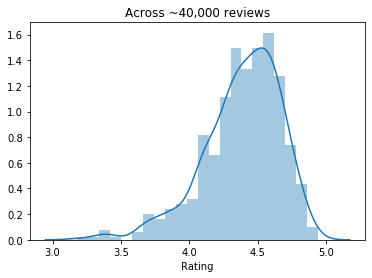

In [4]:
mean_ratings = df.groupby('product').mean()['rating']
sns.distplot(mean_ratings,kde=True)
plt.xlabel('Rating')
plt.title('Across ~40,000 reviews')
plt.savefig('plots/individual-ratings-histogram.png',bbox_inches='tight')

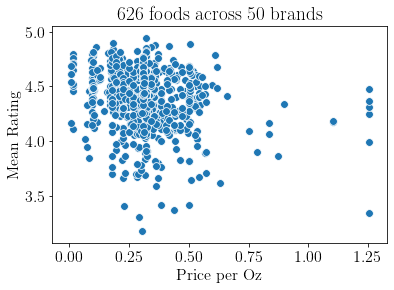

In [12]:
font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)



ratings_vs_price = df.groupby('product').mean()[['rating','price_per_oz']]
plt.title('626 foods across 50 brands')
sns.scatterplot(x='price_per_oz',y='rating',s=60,data=ratings_vs_price)
plt.xlabel('Price per Oz');
plt.ylabel('Mean Rating');
plt.savefig('plots/rating_vs_price.png',bbox_inches='tight')

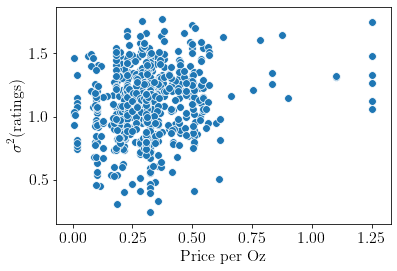

In [13]:
from scipy.stats import entropy
import numpy as np


price = df.groupby('product')['price_per_oz'].mean()
# stdevs = df.groupby('product')['rating'].apply(lambda r: entropy(r.value_counts()))
stdevs = df.groupby('product')['rating'].std()

stdev_vs_price = pd.DataFrame(data={'ppo': price, 'stdev': stdevs})
sns.scatterplot(x='ppo',y='stdev',data=stdev_vs_price,s=60)


# plt.hlines( y=np.log(2), xmin = price.min(), xmax = price.max())

# plt.title('Cat food is polarizing')
plt.xlabel('Price per Oz')
plt.ylabel("$\displaystyle \sigma^2 $(ratings)")
plt.savefig('plots/variance-vs-price.png',bbox_inches='tight')

## random tfidf stuff. skip down below

In [3]:
corpus = df['review_text']
tfidf = TfidfVectorizer(ngram_range=(1, 1), 
                        min_df=0.0001, 
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(corpus)

In [5]:
tfidf_matrix.shape

(38559, 5897)

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
remove_punct = re.compile()

### following https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d 
and(?)
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [5]:
# standardize text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    for brandname in brandnames:
        df[text_field] = df[text_field].str.replace(brandname.lower(),"")

        
    return df

# Function for tokenizing
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


# Label encode the names
le = preprocessing.LabelEncoder()
df['product_label']=le.fit_transform(df['product'])

# print(train_documents[0])

df_clean = standardize_text(df,'review_text')

In [38]:
from nltk.tokenize import RegexpTokenizer
pd.set_option('display.width',200)

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
df_clean["tokens"] = df_clean["review_text"].apply(tokenizer.tokenize)

df_clean['tokens'] = df_clean['tokens'].apply(lambda x: ' '.join( [item for item in x if item not in stop_words]))


all_tokens = [t.split() for t in df_clean['tokens']]
phrases = Phrases(all_tokens)
bigram = Phraser(phrases)
trigram_phrases = Phrases(bigram[all_tokens])
trigram = Phraser(phrases)

df_clean['trigrammed'] = df_clean['tokens'].apply(lambda x: trigram[x.split(' ')])



# train, test = train_test_split(df[['review_text','product_label']],test_size=0.0)

data = df_clean[['trigrammed','product_label']]
data['n_words'] = data['trigrammed'].apply(lambda r: len(r))
print(f'Number of reviews prior to dropping short ones {len(data)}')
data = data.loc[data['n_words']>=10]
print(f'Number of reviews after dropping short ones {len(data)}')
# data.head(5)

data_tagged = data.apply(
    lambda r: TaggedDocument(words=r['trigrammed'], tags=[r.product_label]), axis=1)

# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=bigram[tokenize_text(r['review_text'])], tags=[r.product_label]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=bigram[tokenize_text(r['review_text'])], tags=[r.product_label]), axis=1)

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of reviews prior to dropping short ones 40508
Number of reviews after dropping short ones 29083


In [39]:
pd.set_option('display.max_colwidth',200)
data.sample(5)

,trigrammed,product_label,n_words
28468,"[cat, piper, loves, little, feast, also, likes, beef, flavor, makes_happy, kitty, makes_happy, owner]",104,13
30705,"[may, picky, cats, touch, food, makes, mad, eat, hard, food]",397,10
41421,"[4, cats, currently, 3, foster_kittens, every_morning, give, cats, spoonful, canned, food, start, mornings, look_forward, 1, cans, feeds, 7, morning, much, economical, smaller_cans, much, cheaper,...",183,33
37668,"[kitty, loves, food, love, ingredients, happy, found, peaks, purest, food, market, besides, raw, course, recommend, food, 100, pricey, definitely_worth]",623,19
11233,"[snickers, loves, gravy, rather, picky, walk_away, cat, food, suit, snickers, never, walks_away, intense_beauty, chunks]",493,14


In [41]:

import multiprocessing
cores = multiprocessing.cpu_count()
data_tagged.sample(1).values[0]

TaggedDocument(words=['cat', 'loves', 'tiki', 'ahi_tuna', 'finally_found', 'grain_free', 'chicken', 'free', 'canned', 'cat', 'food', 'reasonably_priced', 'chewy', 'service', 'usual', 'quick', 'flawless'], tags=[545])

In [42]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores,
                    alpha=0.05)
model_dm = Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0,
                   workers=cores, alpha=0.05, comment='alpha=0.05')
model_dbow.build_vocab([x for x in tqdm(data_tagged.values)])
model_dm.build_vocab([x for x in tqdm(data_tagged.values)])

100%|██████████| 29083/29083 [00:00<00:00, 1017100.88it/s]


In [43]:
%%time
cores = multiprocessing.cpu_count()

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(data_tagged.values)]), total_examples=len(data_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    model_dm.train(utils.shuffle([x for x in tqdm(data_tagged.values)]), total_examples=len(data_tagged.values), epochs=1)

100%|██████████| 29083/29083 [00:00<00:00, 1394058.92it/s]


CPU times: user 3min 56s, sys: 28.8 s, total: 4min 24s
Wall time: 3min 16s


In [ ]:
# # Takes a long time to run!

# def vec_for_learning(model, tagged_docs):
#     sents = tagged_docs.values
#     targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
#     return targets, regressors


# y_train, X_train = vec_for_learning(model_dbow, train_tagged)
# y_test, X_test = vec_for_learning(model_dbow, test_tagged)
# logreg = LogisticRegression(n_jobs=1, C=1e5)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# from sklearn.metrics import accuracy_score, f1_score
# print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
# print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [11]:
df.sample(4)[['product','product_label']]

,product,product_label
39273,"Natural Balance Platefulls Chicken & Pumpkin Formula in Gravy Grain-Free Cat Food Pouches, 3-oz pouch, case of 24",349
7335,"Royal Canin Veterinary Diet Recovery RS Canned Dog & Cat Food, 5.8-oz, case of 24",504
1262,"Blue Buffalo Freedom Indoor Kitten Chicken Recipe Grain-Free Canned Cat Food, 3-oz, case of 24",35
20083,"Fancy Feast Marinated Morsels Chicken Feast in Gravy Canned Cat Food, 3-oz, case of 24",156


In [44]:
label_decoder = df[['product_label','product']].set_index('product_label').to_dict()['product']
label_encoder = df[['product_label','product']].set_index('product').to_dict()['product_label']

num_returned = 50
results_shown = 10

pd.set_option('display.max_colwidth', 200)
positives = [67,2]
negatives = [228,361]
positives = [2]
negatives = []

similarity_results = pd.DataFrame(index = product_info['product'],columns = ['dbow_rank','dm_rank','combined'])
similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
#     print(similar_items)
decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

print("Dbow model similarities:")
for (rank, product) in enumerate(decoded_dbow):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dbow_rank"] = rank
    print(f'{rank}: {name}, {score}')

print("\n DM model similarities:")
for (rank, product) in enumerate(decoded_dm):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dm_rank"] = rank
    print(f'{rank}: {name}, {score}')

similarity_results.fillna(value=num_returned+1,inplace=True)
similarity_results["combined"] = (similarity_results["dbow_rank"] + similarity_results["dm_rank"])/2


print(f'Cat liked: {label_decoder[30]}, {label_decoder[7]}. Cat disliked: {label_decoder[183]}, {label_decoder[215]}')
print("\n Combined scores")
similarity_results.sort_values(by='combined',ascending=True).drop(columns=['dbow_rank','dm_rank'],axis=0).head(results_shown)




Dbow model similarities:
0: Dave's Pet Food Naturally Healthy Grain-Free Turkey Formula Canned Cat Food, 12.5-oz, case of 12, 0.6991697549819946
1: Triumph Chicken 'N Liver Formula Canned Cat Food, 13.2-oz, case of 12, 0.696044921875
2: Sheba Perfect Portions Grain-Free Signature Tuna Cuts in Gravy Entree Cat Food Trays, 2.6-oz, case of 24 twin-packs, 0.6883033514022827
3: Fancy Feast Gourmet Naturals Tuna Recipe in Gravy Canned Cat Food, 3-oz, case of 12, 0.6864579916000366
4: Fancy Feast Grilled Tuna Feast in Gravy Canned Cat Food, 3-oz, case of 24, 0.684238612651825
5: Fancy Feast Flaked Fish & Shrimp Feast Canned Cat Food, 3-oz, case of 24, 0.6815081834793091
6: Tiki Cat Koolina Luau Chicken with Egg in Chicken Consomme Grain-Free Canned Cat Food, 6-oz, case of 8, 0.6788089275360107
7: Friskies Savory Shreds with Ocean Whitefish & Tuna in Sauce Canned Cat Food, 5.5-oz, case of 24, 0.6771600246429443
8: Sheba Perfect Portions Grain-Free Roasted Chicken & Liver Entree Cat Food Trays,

,combined
product,
"Fancy Feast Grilled Tuna Feast in Gravy Canned Cat Food, 3-oz, case of 24",2.0
"Sheba Perfect Portions Grain-Free Signature Tuna Cuts in Gravy Entree Cat Food Trays, 2.6-oz, case of 24 twin-packs",10.5
"Friskies Savory Shreds with Ocean Whitefish & Tuna in Sauce Canned Cat Food, 5.5-oz, case of 24",15.0
"Fancy Feast Flaked Tuna & Mackerel Feast Canned Cat Food, 3-oz, case of 24",18.0
"Friskies Classic Pate Supreme Supper Canned Cat Food, 5.5-oz, case of 24",25.0
"Dave's Pet Food Naturally Healthy Grain-Free Turkey Formula Canned Cat Food, 12.5-oz, case of 12",25.5
"Friskies Flaked with Tuna in Sauce Canned Cat Food, 5.5-oz, case of 24",26.0
"Triumph Chicken 'N Liver Formula Canned Cat Food, 13.2-oz, case of 12",26.0
"Solid Gold Five Oceans Shreds with Real Tuna Recipe in Gravy Grain-Free Canned Cat Food, 6-oz, case of 8",26.5


In [45]:
af = product_info
af['product_label']=le.fit_transform(af['product'])
brand_list = {name : brand for (name,brand) in zip(af['product'],af['brand'])}

sample_brands = ['Fancy Feast',
                 'Friskies',
                 'Blue Buffalo',
                 'Purina Pro Plan', 
                 'Hills Prescription Diet',
#                  'Weruva',
                 'Wellness',
                ]



In [46]:
vec_list = {name : model_dbow.docvecs[x] for (name,x) in zip(af['product'].to_list(),af['product_label'].to_list()) if brand_list[name] in sample_brands
           };

embeddings = pd.DataFrame.from_dict(vec_list,orient='index')

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


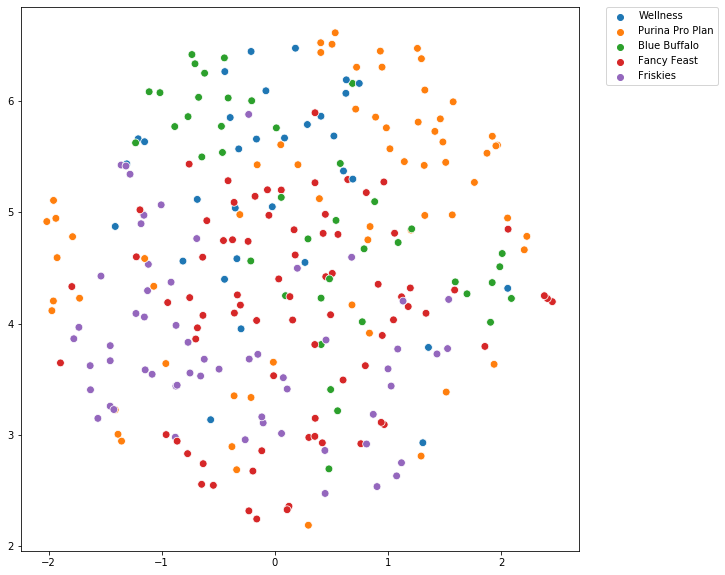

In [47]:
# from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import umap 

%matplotlib inline
# pca = PCA(n_components=2)
embeddings_viz = umap.UMAP(min_dist = 0.03).fit_transform(embeddings)
brand_name = [brand_list[name] for name in embeddings.index]

fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=embeddings_viz[:,0], y=embeddings_viz[:,1],hue = brand_name, s = 60)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig('plots/BrandSeparation.png',bbox_inches='tight')



In [16]:
product_info[product_info['brand']=="Nutro"]['product'].values

array(['Nutro Perfect Portions Grain-Free Salmon & Tuna Recipe Cat Food Trays, 2.6-oz, case of 24',
       'Nutro Adult Chunky Loaf  Salmon & Tuna Dinner Grain-Free Canned Cat Food, 3-oz, case of 24',
       'Nutro Kitten Soft Loaf Chicken Recipe Grain-Free Canned Cat Food, 3-oz, case of 24',
       'Nutro Perfect Portions Grain-Free Chicken Recipe Cat Food Trays, 2.6-oz, case of 24',
       'Nutro Perfect Portions Grain-Free Turkey Recipe Cat Food Trays, 2.6-oz, case of 24',
       'Nutro Adult Sliced Chicken & Tuna Entrée in Savory Sauce Grain-Free Canned Cat Food, 3-oz, case of 24',
       'Nutro Senior Minced Cod & Tuna Cuisine in Tasty Gravy Grain-Free Canned Cat Food, 3-oz, case of 24'],
      dtype=object)

In [184]:
import pickle
# save what we need to use in the backend

# the model
model_dbow.save('catfood-d2v-dbow.model')
model_dm.save('catfood-d2v-dm.model')

# the label decoder
with open("label-decoder.pkl","wb") as f:
    pickle.dump(label_decoder,f)
    
# the label encoder
with open("label-encoder.pkl","wb") as f:
    pickle.dump(label_encoder,f)



## validation attempts, pray to god

In [79]:
author_count = df.groupby('review_author')['review_author'].count()
authorgroup = author_count[(author_count > 5) & (author_count < 15)]
# authorgroup
# authorgroup = author_count

In [80]:
import numpy as np
def scale_scores(df,field):
    scaleby = max(np.abs(df[field].min()),np.abs(df[field].max()))
    df[field] = df[field]/scaleby
    return df

def generate_val_data(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    if len(userdata.groupby('rating').count()) == 1:
        return
    
    

    
    low_rankings = userdata[userdata['rating'] <= 3].sort_values(by='rating',ascending=True)
    high_rankings = userdata[userdata['rating'] >= 4].sort_values(by='rating',ascending=False)
    
    
#     if len(low_rankings) < 3:
#         return
    
    
    negatives = [val for val in low_rankings.head(2)['product_label']]
    positives = [val for val in high_rankings.head(2)['product_label']]
    
    similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)

    decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
    decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

    dbow_results = pd.DataFrame(decoded_dbow,columns=['product','sim_score'])
    dbow_results = scale_scores(dbow_results,'sim_score')

    dm_results = pd.DataFrame(decoded_dm,columns=['product','sim_score'])
    dm_results = scale_scores(dm_results,'sim_score')

    combined_results = dbow_results.set_index('product').join(dm_results.set_index('product'), how = 'left', 
                                        lsuffix = '_db', rsuffix = '_dm')


    combined_results['avg_sim'] = (combined_results['sim_score_db'] + combined_results['sim_score_dm'])/2
    
    tmp = userdata[['product','rating']].set_index('product')
    val = tmp.join(combined_results,how='left')
    val.dropna(how='any',axis=0,inplace=True)
    
#     val['rating'] = val['rating'] - val['rating'].mean()
    
    return val

In [81]:
val = pd.concat([generate_val_data(user) for user in authorgroup.index],axis=0)

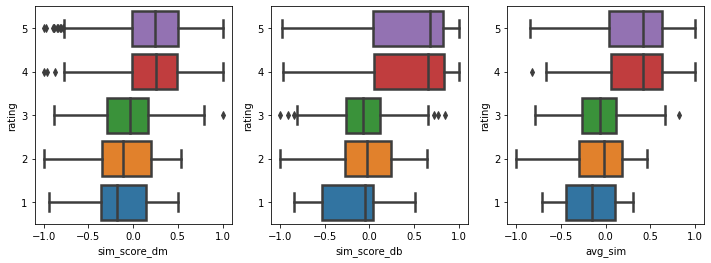

In [82]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))


a = sns.boxplot(x='sim_score_dm',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[0])
a.invert_yaxis()

b = sns.boxplot(x='sim_score_db',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[1])
b.invert_yaxis()

c = sns.boxplot(x='avg_sim',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[2])
c.invert_yaxis()